In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
%matplotlib inline

In [2]:
from Gaussian import GAUSSIAN
#from SVN import SVN
#from LaplaceSVN import LaplaceSVN
from DoubleBanana import DOUBLEBANANA
from NonLinRegresssion import NONLINREGRESSION

In [16]:

class SVN:
    def __init__(self, model, *arg):
        self.model = model
        self.DoF = model.DoF
        self.nParticles = 5
        self.nIterations = 1
        self.stepsize = 1
        self.MAP = self.model.getMAP( np.random.normal( size = self.DoF ) )[:,np.newaxis]
        if len(arg) == 0:
            self.resetParticles()
        else:
            self.particles = arg[0]
        
    def apply(self):
        maxmaxshiftold = np.inf
        maxshift = np.zeros(self.nParticles)
        Q = np.zeros( (self.DoF, self.nParticles) )
        

        for iter_ in range(self.nIterations):
            F = self.model.getForwardModel(self.particles)
            J = self.model.getJacobianForwardModel(self.particles)

        
            gmlpt  = self.model.getGradientMinusLogPosterior(self.particles, F, J)
            Hmlpt  = self.model.getGNHessianMinusLogPosterior(self.particles, J)
            

            M = np.mean(Hmlpt, 2)

            
            for i_ in range(self.nParticles):

                #difference of particle to all other particles
                sign_diff = self.particles[:,i_,np.newaxis] - self.particles

                #adjusts for mean curvature
                Msd   = np.matmul(M, sign_diff)
                
                #caluclates kernel x w.r.t. to all other x'
                kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
                
                #calculates gradient with analytial chain rule
                gkern = Msd * kern

                #averahe gradJ, from SVGD
                #t1 = - gmlpt * kern + gkern #(n_parameters, n_particles)
                #print('T1: ', t1)
                #print('t1 shape: ', t1.shape)

                mgJ = np.mean(- gmlpt * kern + gkern , 1) # (n_parametes, )

                #print(mgJ)
                #print(mgJ.shape)

                #calculates hessian 
                HJ  = np.mean(Hmlpt * kern ** 2, 2) + np.matmul(gkern, gkern.T) / self.nParticles

                print('hessian shape: ', HJ.shape)
                print('mgJ shaoe: , ', mgJ)

                #solves decoupled systems of linear equations
                Q[:,i_] = np.linalg.solve(HJ, mgJ)

                #maximum shift
                maxshift[i_] = np.linalg.norm(Q[:,i_], np.inf)


            self.particles += self.stepsize * Q
            maxmaxshift = np.max(maxshift)
            
            if np.isnan(maxmaxshift) or (maxmaxshift > 1e20):
                print('Reset particles...')
                self.resetParticles()
                self.stepsize = 1
            elif maxmaxshift < maxmaxshiftold:
                self.stepsize *= 1.01
            else:
                self.stepsize *= 0.9
            maxmaxshiftold = maxmaxshift
                          
    def resetParticles(self):
        self.particles = np.random.normal( scale = 1, size = (self.DoF, self.nParticles) )

In [17]:
model = GAUSSIAN()

In [18]:
svn = SVN(model)


In [19]:
svn.apply()


T1:  [[-5.44824897 -0.8798623   0.30545452  0.18064232 -2.98665389]
 [-1.86892348  0.31012976  0.16868555  0.25643009 -0.62415717]]
t1 shape:  (2, 5)
[-1.76573366 -0.35156705]
(2,)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-1.76573366 -0.35156705]
T1:  [[-0.8146673  -5.58980765  0.32464016  0.37503702 -0.92678302]
 [-0.58543224  0.07562091 -0.03095833  0.01719025 -0.73260303]]
t1 shape:  (2, 5)
[-1.32631616 -0.25123649]
(2,)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-1.32631616 -0.25123649]
T1:  [[-0.9898969  -1.03381701 -1.23321496 -2.50937538 -2.23291461]
 [-0.37151871  0.02726908 -0.11111528  0.23194493 -0.71925307]]
t1 shape:  (2, 5)
[-1.59984377 -0.18853461]
(2,)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-1.59984377 -0.18853461]
T1:  [[-1.1297581  -2.20091869 -0.40623663 -2.01399171 -2.43678127]
 [-0.48477513  0.01864287 -0.26562527  0.07360446 -0.93741209]]
t1 shape:  (2, 5)
[-1.63753728 -0.31911303]
(2,)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-1.63753728 -0.31911303]
T1:  [[-5.40850078 -1.82

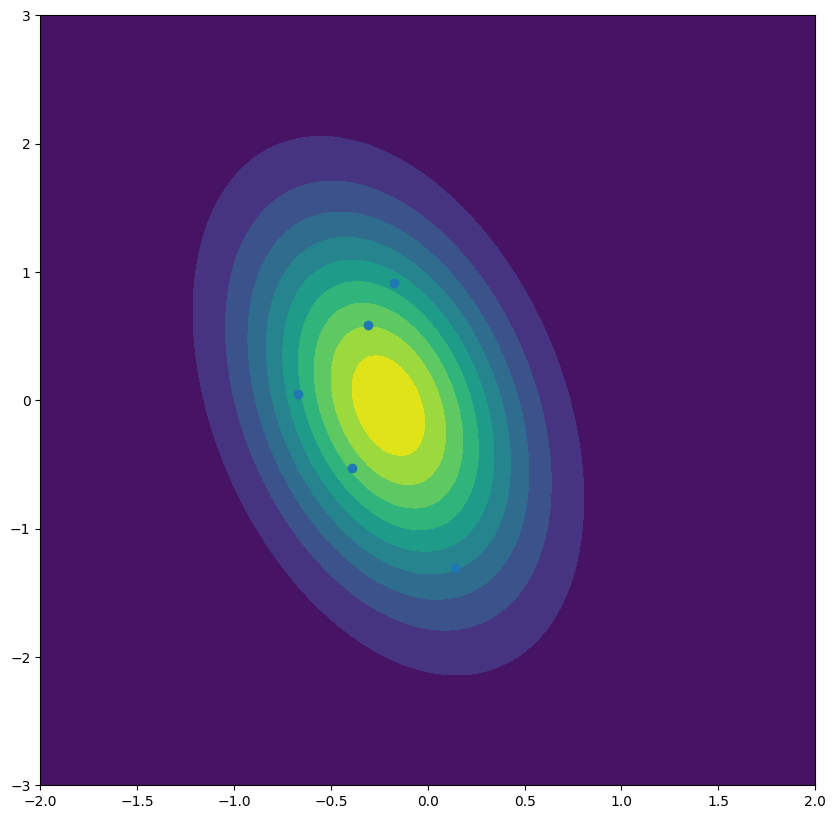

In [7]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-3, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [8]:
model = DOUBLEBANANA()

In [9]:
svn = SVN(model)


In [10]:
svn.apply()

T1:  [[-8.88323399e+001  9.37289225e-199  1.39713678e-215 -7.56562181e-077
   2.02216804e-173]
 [ 1.86060438e+001 -9.08372578e-199 -1.68391200e-215  1.41507373e-075
  -2.56226630e-173]]
t1 shape:  (2, 5)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-17.76646799   3.72120875]
T1:  [[-1.32984933e-198 -6.57195367e+001 -5.57523405e-003 -1.68717847e-276
  -1.30263694e-024]
 [ 1.12111645e-198  6.51517420e+001 -1.20681838e-003  2.58529780e-276
  -6.43861772e-024]]
t1 shape:  (2, 5)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-13.14502239  13.03010704]
T1:  [[-2.02746614e-215 -5.46312669e-003 -7.51913619e+001 -0.00000000e+000
  -8.70837317e-049]
 [ 1.95242885e-215  1.03265798e-002  5.12671549e+001  0.00000000e+000
  -1.24603840e-048]]
t1 shape:  (2, 5)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-15.03936501  10.25549629]
T1:  [[-7.02675754e-076  1.22604744e-276  0.00000000e+000 -5.69729817e+001
   1.00960882e-168]
 [-1.16894445e-075 -2.23706731e-276  0.00000000e+000  2.75014795e+001
  -2.07272796e-168]]
t1 shap

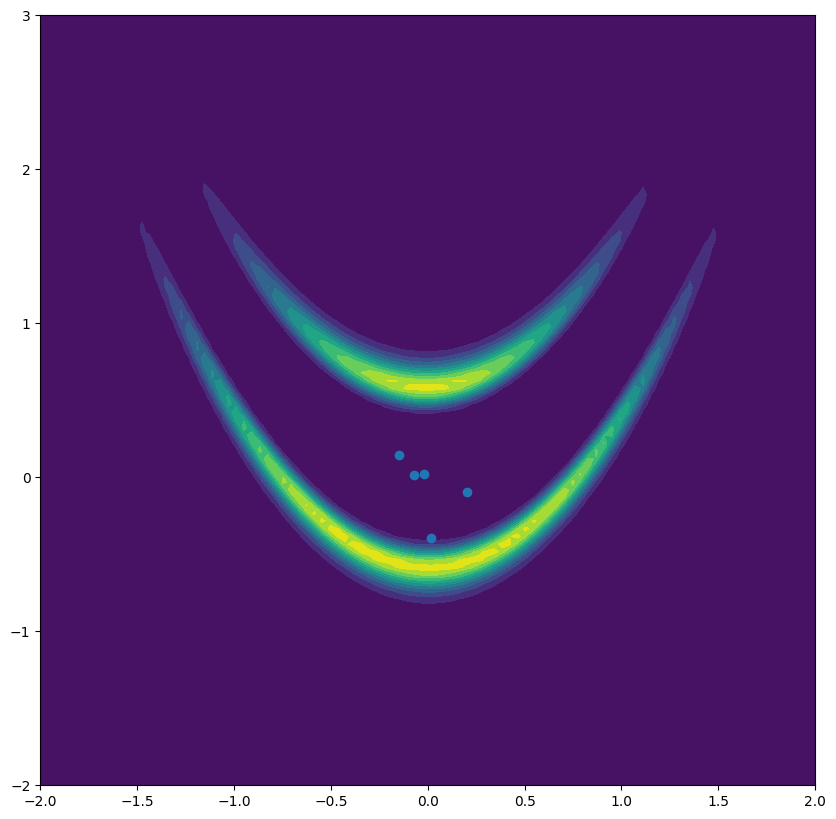

In [11]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-2, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [12]:
model = NONLINREGRESSION()

In [13]:
svn = SVN(model)

In [14]:
svn.apply()

T1:  [[-2.17070628e+003  0.00000000e+000  4.27227645e-296  8.57647970e-229
   0.00000000e+000]
 [-1.37790624e+002  0.00000000e+000  2.54540184e-297  8.04373859e-230
   0.00000000e+000]]
t1 shape:  (2, 5)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-434.14125578  -27.55812477]
T1:  [[-0.00000000e+00 -6.67605547e+00 -2.56939676e-06 -4.23709267e-27
   4.32372801e-30]
 [-0.00000000e+00 -9.21997150e+00 -4.57230064e-07 -1.43918067e-28
   4.52748264e-31]]
t1 shape:  (2, 5)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-1.33521161 -1.84399439]
T1:  [[-1.50171941e-295  2.11367391e-006 -2.28289159e+001 -9.31507649e-010
   3.02531184e-069]
 [-1.00542671e-296  7.54132435e-008 -1.55000846e+001  3.92913791e-011
   3.10299655e-070]]
t1 shape:  (2, 5)
hessian shape:  (2, 2)
mgJ shaoe: ,  [-4.56578275 -3.10001691]
T1:  [[-3.27418657e-228  3.97613164e-027  6.82023276e-010 -9.62694625e+000
   4.18827005e-109]
 [-2.34870525e-229 -2.84344495e-029 -1.70333346e-010 -1.54739604e+000
   2.90061351e-110]]
t1 shape:  (2, 5)
h

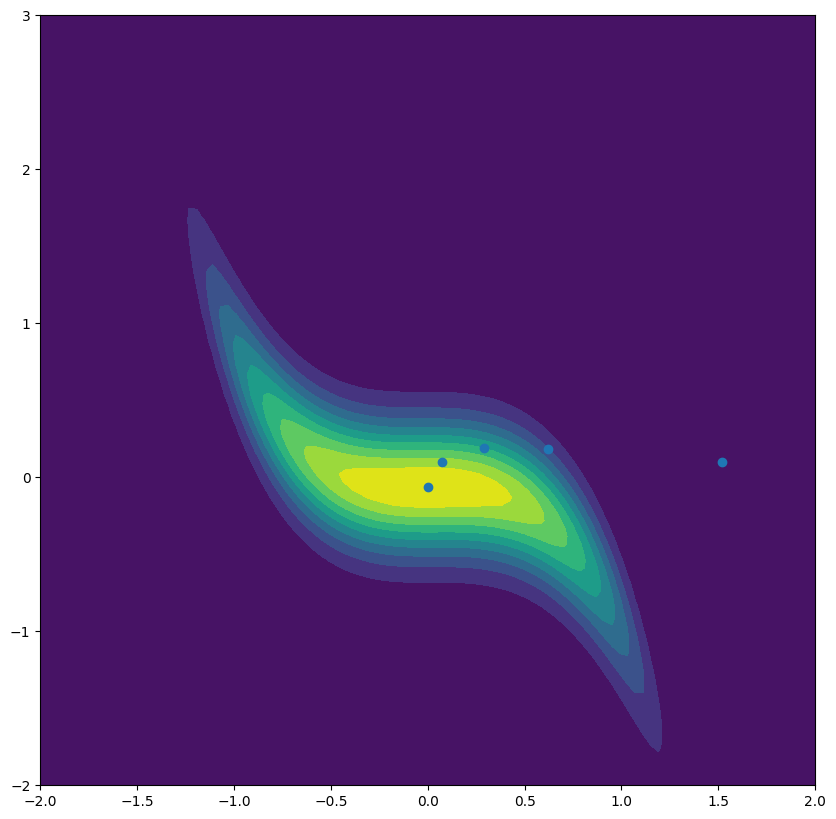

In [15]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-2, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])